In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.models import Model

2023-10-09 12:52:54.670860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 12:52:54.698509: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 12:52:54.699156: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 12:52:55.309985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data

In [3]:
n_el = 16
r_obj = 0.4
dist_exc = 8
step_meas = 4

load_path = f"saves/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

You have to generate the data...


In [4]:
V = np.load("saves/" + load_path.split("/")[1] + "_v_data.npy", allow_pickle=True)

In [5]:
np.allclose(V[0], V[248])

False

In [6]:
# creates overlapping segments with a length of nseg
nseg = 2
X0 = [V[n : n + nseg, :] for n in range(V.shape[0] - nseg + 1)]  # is this nseg+1 right?
X0 = np.array(X0)

Y0 = np.array(V[nseg - 1 :])  # is this -1 right?

In [7]:
# proof that the shift is right
print(np.allclose(X0[0], V[0:nseg, :]))
print(np.allclose(X0[244], V[244 : 244 + nseg, :]))

True
True


In [8]:
x_train, x_val, y_train, y_val = train_test_split(X0, Y0, test_size=0.2, shuffle=False)
# x_val, y_val = train_test_split(Y0, test_size=0.2, shuffle=False)

In [9]:
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(198, 2, 192) (50, 2, 192)
(198, 192) (50, 192)


In [10]:
X0.shape

(248, 2, 192)

In [11]:
def lstm_split(input_shape, nseg):
    def Slice(s):
        # function for slicing x
        def func(x):
            return x[:, s, :]

        return func

    # define shared layers
    dense = Dense(192, activation="relu")

    inputs = Input(shape=input_shape)

    con_list = []
    for s in range(nseg):
        # slicing x
        x = Lambda(Slice(s))(inputs)

        # shared layers
        x = dense(x)

        con_list.append(x)

    # concat and reshape for LSTM
    x = Concatenate(axis=1)(con_list)
    x = Reshape((nseg, int(x.shape[1] / nseg)))(x)

    x = LSTM(192)(x)
    x = Activation("softmax")(x)

    return Model(inputs, x)

In [12]:
model = lstm_split(input_shape=(X0.shape[1], X0.shape[2]), nseg=nseg)
model.compile(optimizer="adam", loss="MeanSquaredError")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2, 192)]             0         []                            
                                                                                                  
 lambda (Lambda)             (None, 192)                  0         ['input_1[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 192)                  0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 192)                  37056     ['lambda[0][0]',              
                                                                     'lambda_1[0][0]']        

2023-10-09 12:52:56.393475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [13]:
epochs = 10
batch_size = 16
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
)

Epoch 1/10


2023-10-09 12:52:57.680251: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "240" frequency: 1996 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 2s 29ms/step - loss: 0.3355 - val_loss: 0.3348
Epoch 2/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3344 - val_loss: 0.3337
Epoch 3/10
 1/13 [=>............................] - ETA: 0s - loss: 0.3337

2023-10-09 12:52:58.224594: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "240" frequency: 1996 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


13/13 [==============================] - 0s 7ms/step - loss: 0.3337 - val_loss: 0.3335
Epoch 4/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3336 - val_loss: 0.3334
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3335 - val_loss: 0.3334
Epoch 6/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3335 - val_loss: 0.3334
Epoch 7/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3335 - val_loss: 0.3334
Epoch 8/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3335 - val_loss: 0.3334
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3335 - val_loss: 0.3334
Epoch 10/10
13/13 [==============================] - 0s 6ms/step - loss: 0.3335 - val_loss: 0.3334


In [14]:
predictions = model.predict(x_val)

2/2 [==============================] - 0s 3ms/step


2023-10-09 12:52:59.239385: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } attr { key: "_has_manual_control_dependencies" value { b: true } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "AuthenticAMD" model: "240" frequency: 1996 num_cores: 16 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 524288 l3_cache_size: 16777216 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


<StemContainer object of 3 artists>

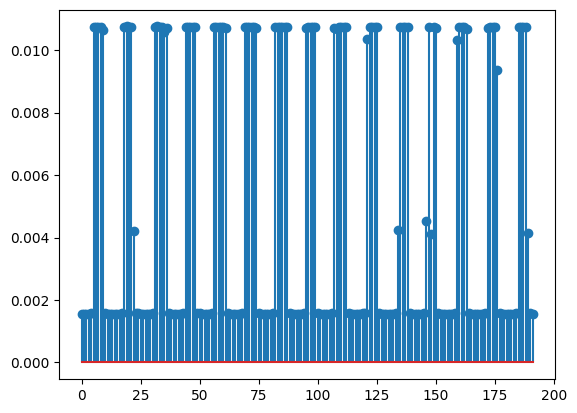

In [15]:
plt.stem(predictions[0])

<StemContainer object of 3 artists>

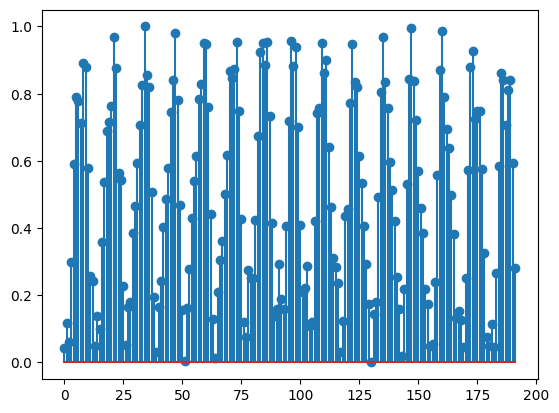

In [16]:
plt.stem(y_val[0])